<a href="https://colab.research.google.com/github/nguyendat1811884/Data-Science-From-Theory-To-Practice/blob/main/Analytic_Report/Analytic_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import các thư viện cần thiết**

In [1543]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly.graph_objects as gp

from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

## **Dowload và đọc data**

In [1544]:
!gdown --id 1DDT3u1YNlJGsxHuUlQNzNhpx_GnINHOq

Downloading...
From: https://drive.google.com/uc?id=1DDT3u1YNlJGsxHuUlQNzNhpx_GnINHOq
To: /content/Kaggle_HR_Employee_Attrition.csv
100% 228k/228k [00:00<00:00, 69.1MB/s]


In [1545]:
df = pd.read_csv('/content/Kaggle_HR_Employee_Attrition.csv')

In [1546]:
df.shape

(1470, 35)

*   Cấu trúc tập dữ liệu: có tổng cộng 1470 data point (hàng) và 35 feature (cột) 

Hãy xem thử một vài data point đầu tiên:

In [1547]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [1548]:
df.dtypes.value_counts()

int64     26
object     9
dtype: int64

* Chỉ có 2 loại datatypes trong toàn bộ tập dataset: kiểu số nguyên và kiểu object 

In [1549]:
impact_to_attrition = []
impact_to_satisfaction = []
anova_col_list = []

## **Data normalization**

Ta thấy rằng, vùng giá trị của các feature rất khác nhau, vì thế ta cần chuẩn hóa các feature này để phạm vi các giá trị nhất quán với nhau. Điều này giúp cho việc thực hiện một số phân tích thống kê được dễ dàng hơn.<br>
Ta có thể dùng một trong ba cách normalization sau:<br>


1.   Simple feature scaling: chia mỗi giá trị của feature cho max của feature đó => result thuộc [0, 1]
2.   Min-Max: với mỗi giá trị của feature ta thực hiện gán lại bằng ***(x - x_min) / (x_max - x_min)*** => result thuộc [0, 1]
3.   Z-score:  với mỗi giá trị của feature ta thực hiện gán lại bằng ***(x - mean) / std*** => result nằm xung quanh 0, thường từ -3 đến 3 nhưng cũng có thể cao hoặc thấp hơn




## **Kiểm tra, xử lý missing value**

In [1550]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [1551]:
%%time
missing_data(df)

CPU times: user 14 ms, sys: 993 µs, total: 15 ms
Wall time: 15.7 ms


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,object,int64,object,int64,int64,object,int64,int64,int64,object,int64,int64,int64,object,int64,object,int64,int64,int64,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [1552]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [1553]:
# remove cac hang co missing value (neu co)
# df.dropna(axis=0, inplace = True) or
df = df.dropna(axis=0)

# df.dropna(axis=0) => Khong lam thay doi dataframe

In [1554]:
def replace_na(df, col, val):
  df[col].replace(np.nan, val)
  return df

In [1555]:
def convert_data_type(df, col, ntype):
  df[col].astype(ntype)
  return df

In [1556]:
# Kiem tra cac hang trung lap nhau
duplicateRows = df[df.duplicated()]
if not duplicateRows.empty:
  print(duplicateRows)
else:
  print('Khong co hang nao trung lap')


Khong co hang nao trung lap


In [1557]:
def binning(df, col, group_names):
  bins = np.linspace(min(df[col]), max(df[col]), len(group_names) + 1)
  df[col + '_binned'] = pd.cut(df[col], bins, labels=group_names, include_lowest=True)
  

## **Thống kê mô tả**




1.   Kiểm tra các số liệu "bất thường": xem xét số tối đa
> Xem xét số tối đa, tối thiểu<br>
> Tính hợp lý (validity)<br>
> Tính nhất quán (consistency)<br>
> Lẫn lộn biến

2.   Xác định muc tiêu phân tích, thông điệp muốn chuyển tải
3.   Xác định các biến số cần thiết
4.   Xác định phương pháp thống kê
> Tùy thuộc mục tiêu và biến số<br>
> Mô tả: mean, standard deviation, median, proportion,..<br>
> Tương quan: regression models<br>
> So sánh 2 nhóm: 
>> Biến liên tục: T-test, Wilcoxon's signed rank test, permutation,..
>> Biến phân nhóm: Chi-squared test, Binomial test
5.   Xác định lệnh, hàm trong python









In [1558]:
pd.set_option('precision', 3)

**<h5> Categorical data**

In [1559]:
df.describe(percentiles=[.01, .25, .5, .75, .99], include='object')

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,882,326,673,1470,1054


In [1560]:
business_travel_count = df['BusinessTravel'].value_counts().to_frame()
business_travel_count

,BusinessTravel
Travel_Rarely,1043
Travel_Frequently,277
Non-Travel,150


In [1561]:
marital_status_count = df['MaritalStatus'].value_counts().to_frame()
marital_status_count

,MaritalStatus
Married,673
Single,470
Divorced,327


In [1562]:
over_time_count = df['OverTime'].value_counts().to_frame()
over_time_count

,OverTime
No,1054
Yes,416


**<h5> Numeric data <h5>**

In [1563]:
df.describe(percentiles=[.01, .25, .5, .75, .99])

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000,1470.000,1470.000,1470.000,1470.0,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.00,1470.000,1470.000,1470.0,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000
mean,36.924,802.486,9.193,2.913,1.0,1024.865,2.722,65.891,2.730,2.064,2.729,6502.931,14313.103,2.693,15.21,3.154,2.712,80.0,0.794,11.280,2.799,2.761,7.008,4.229,2.188,4.123
std,9.135,403.509,8.107,1.024,0.0,602.024,1.093,20.329,0.712,1.107,1.103,4707.957,7117.786,2.498,3.66,0.361,1.081,0.0,0.852,7.781,1.289,0.706,6.127,3.623,3.222,3.568
min,18.000,102.000,1.000,1.000,1.0,1.000,1.000,30.000,1.000,1.000,1.000,1009.000,2094.000,0.000,11.00,3.000,1.000,80.0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1%,19.000,117.000,1.000,1.000,1.0,19.690,1.000,30.000,1.000,1.000,1.000,1382.460,2325.070,0.000,11.00,3.000,1.000,80.0,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
25%,30.000,465.000,2.000,2.000,1.0,491.250,2.000,48.000,2.000,1.000,2.000,2911.000,8047.000,1.000,12.00,3.000,2.000,80.0,0.000,6.000,2.000,2.000,3.000,2.000,0.000,2.000
50%,36.000,802.000,7.000,3.000,1.0,1020.500,3.000,66.000,3.000,2.000,3.000,4919.000,14235.500,2.000,14.00,3.000,3.000,80.0,1.000,10.000,3.000,3.000,5.000,3.000,1.000,3.000
75%,43.000,1157.000,14.000,4.000,1.0,1555.750,4.000,83.750,3.000,3.000,4.000,8379.000,20461.500,4.000,18.00,3.000,4.000,80.0,1.000,15.000,3.000,3.000,9.000,7.000,3.000,7.000
99%,58.310,1485.000,29.000,5.000,1.0,2046.620,4.000,100.000,4.000,5.000,4.000,19626.310,26704.240,9.000,25.00,4.000,4.000,80.0,3.000,35.000,6.000,4.000,31.000,15.000,14.000,14.000
max,60.000,1499.000,29.000,5.000,1.0,2068.000,4.000,100.000,4.000,5.000,4.000,19999.000,26999.000,9.000,25.00,4.000,4.000,80.0,3.000,40.000,6.000,4.000,40.000,18.000,15.000,17.000


## **Define function**

In [1564]:
# def plot_horizontal_bar_chart(x_, y_, xlabel, ylabel, savename):
#   plt.figure(figsize=(6, 4))
#   splot=sns.barplot(x=x_,y=y_)
#   for p in splot.patches:
#       width = p.get_width()    # get bar length
#       splot.text(width + 1,       # set the text at 1 unit right of the bar
#               p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
#               '{:1.0f}'.format(width), # set variable to display, 2 decimals
#               ha = 'left',   # horizontal alignment
#               va = 'center')  # vertical alignment
#   plt.xlabel(xlabel, size=10)
#   plt.ylabel(ylabel, size=10)
#   plt.savefig(savename)

In [1565]:
def plot_horizontal_bar_chart(x_, y_, xlabel, ylabel, ax_, title):
  # plt.figure(figsize=(6, 4))
  splot=sns.barplot(x=x_,y=y_,ax=ax_)
  for p in splot.patches:
      width = p.get_width()    # get bar length
      splot.text(width + 1,       # set the text at 1 unit right of the bar
              p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
              '{:1.0f}'.format(width), # set variable to display, 2 decimals
              ha = 'left',   # horizontal alignment
              va = 'center')  # vertical alignment
  plt.xlabel(xlabel, size=10)
  plt.ylabel(ylabel, size=10)
  ax_.set_title(title)

In [1566]:
# def plot_pie_chart(labels, sizes):
#   # pie chart of workers
#   # param: labels: list of str
#   #        sizes: list of value_counts
  
#   # print(sizes) # adds up to 1433, which is the total number of participants
#   fig1, ax1 = plt.subplots()
#   ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
#   ax1.axis('equal')
#   plt.show()

In [1567]:
def plot_pie_chart(labels, sizes, ax, title):
  # pie chart of workers
  # param: labels: list of str
  #        sizes: list of value_counts
  
  # print(sizes) # adds up to 1433, which is the total number of participants
  ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False)
  ax.axis('equal')
  ax.set_title(title)

In [1568]:
def plot_density_chart(x, ax_, title):
  ax = sns.kdeplot(x, shade=False, color='crimson', ax=ax_)
  kdeline = ax.lines[0]
  mean = x.mean()
  xs = kdeline.get_xdata()
  ys = kdeline.get_ydata()
  height = np.interp(mean, xs, ys)
  ax.vlines(mean, 0, height, color='crimson', ls=':')
  ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
  ax_.set_title(title)

In [1569]:
def plot_pyramid(df, tickvals, ticktext, title):
  # Creating instance of the figure 
  fig = gp.Figure() 
    
  # Adding Male data to the figure 
  fig.add_trace(gp.Bar(y= df.index.to_list(), x = -1 * df['Attrition'],  
                      name = 'Attrition',  
                      orientation = 'h')) 
    
  # Adding Female data to the figure 
  fig.add_trace(gp.Bar(y = df.index.to_list(), x = df['NoAttrition'], 
                      name = 'No Attrition', orientation = 'h')) 
    
  # Updating the layout for our graph 
  fig.update_layout(title = title, 
                  title_font_size = 22, barmode = 'relative', 
                  bargap = 0.0, bargroupgap = 0, 
                  # xaxis = dict(tickvals = [-300, -250, -200, -150, -100, -50, 
                  #                           0, 50, 100, 150, 200, 250, 300], 
                                  
                  #               ticktext = [300, 250, 200, 150, 100, 50, 
                  #                           0, 50, 100, 150, 200, 250, 300],
                  xaxis = dict(tickvals = tickvals, 
                                  
                                ticktext = ticktext,
                                  
                                title = 'Amount', 
                                title_font_size = 14) 
                  ) 
    
  fig.show()

In [1570]:
def one_way_anova(df1, col):
  anova_col_list.append(col)
  result = df1.groupby(col)['Attrition'].apply(list)
  anova = f_oneway(*result)
  if anova.pvalue < 0.05:
    if 'bins' in col:
      impact_to_attrition.append(col[:len(col) - 5])
    else:
      impact_to_attrition.append(col)
  return anova

In [1571]:
def hypothesis_testing(df, target, col_list):
  impact_list = []
  for col in col_list:
    col_name = col
    if 'bins' in col:
        col_name = col[:len(col) - 5]
    if col_name == target: continue
    print('* ', col_name)
    result = df.groupby(col)[target].apply(list)
    anova = f_oneway(*result)
    print(anova)
    if anova.pvalue < 0.05:
        impact_list.append(col_name)
        print('Bác bỏ H0')
    else:
        print('Chấp nhận H0 với xác suất có ý nghĩa {0}%'.format((1 - anova.pvalue)*100))
    print('--------------------------------------------------')
  return impact_list

In [1572]:
def print_res(res, target):
  print('Các yếu tố ảnh hưởng tới {0}: '.format(target))
  for item in res:
    print('- ', item)

## **EDA**

**Attrition**

In [1573]:
attrition_count = df['Attrition'].value_counts().to_frame()
attrition_count

,Attrition
No,1233
Yes,237


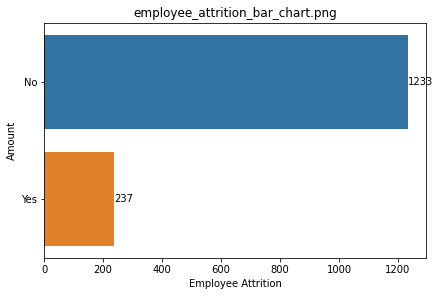

In [1574]:
fig1, axs = plt.subplots(constrained_layout=True)
plot_horizontal_bar_chart(attrition_count['Attrition'], attrition_count.index.tolist(), 'Employee Attrition', 'Amount', axs,'employee_attrition_bar_chart.png')
# plot_horizontal_bar_chart(attrition_count['Attrition'], attrition_count.index.tolist(), 'Employee Attrition', 'Amount', axs[1],'employee_attrition_bar_chart.png')

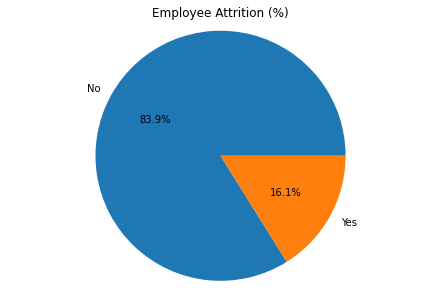

In [1575]:
fig1, axs = plt.subplots(constrained_layout=True)
plot_pie_chart(attrition_count.index.tolist(), attrition_count['Attrition'], axs, 'Employee Attrition (%)')
# plot_pie_chart(over_time_count.index.tolist(), over_time_count['OverTime'], axs[1], 'Employee OverTime (%)')
plt.show()

In [1576]:
# attrition_count.index.tolist()

In [1577]:
# attrition_count['Attrition'].to_list()

* Ta thấy rằng, tỉ lệ nhân viên nghỉ việc chiếm 16.1% thấp hơn rất nhiều so với tỉ lệ 83.9% của nhóm nhân viên không nghỉ việc => **imbalanced data**

In [1578]:
data = df

**<h5> Age <h5>**

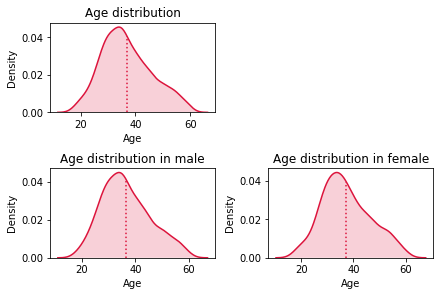

In [1579]:
fig1, axs = plt.subplots(2, 2, constrained_layout=True)
plot_density_chart(df['Age'], axs[0][0], 'Age distribution')
plot_density_chart(df[df['Gender'] == 'Male']['Age'], axs[1][0], 'Age distribution in male')
plot_density_chart(df[df['Gender'] == 'Female']['Age'], axs[1][1], 'Age distribution in female')
axs[0,1].set_visible(False)
plt.show()

* Phân phối về độ tuổi lệch phải (right-skewed) 

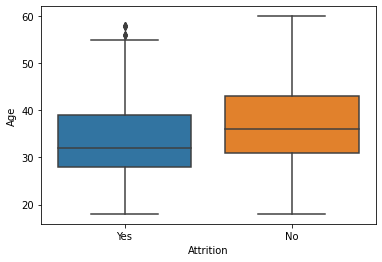

In [1580]:
sns.boxplot(x='Attrition', y='Age', data=df)

* Nhóm người đã nghỉ việc có tuổi trung bình thấp hơn nhóm còn lại
* Có khả năng có một vài điểm dữ liệu bất thường (oulier) trong dữ liệu về độ tuổi của nhóm nhân viên nghỉ việc 

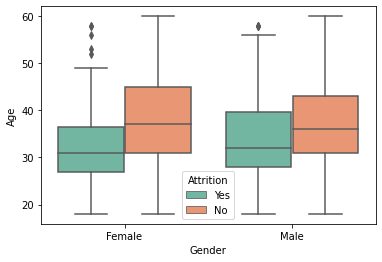

In [1581]:
sns.boxplot(x="Gender", y="Age", hue="Attrition",
                 data=df, palette="Set2")

* Không có nhiều sự khác biệt về độ tuổi trung bình của nhóm người nghỉ việc (và không nghỉ việc) giữa nam so với nữ

**Gender**

In [1582]:
gender_count = df['Gender'].value_counts().to_frame()
gender_count

,Gender
Male,882
Female,588


In [1583]:
male_df = df[df['Gender'] == 'Male']
female_df = df[df['Gender'] == 'Female']

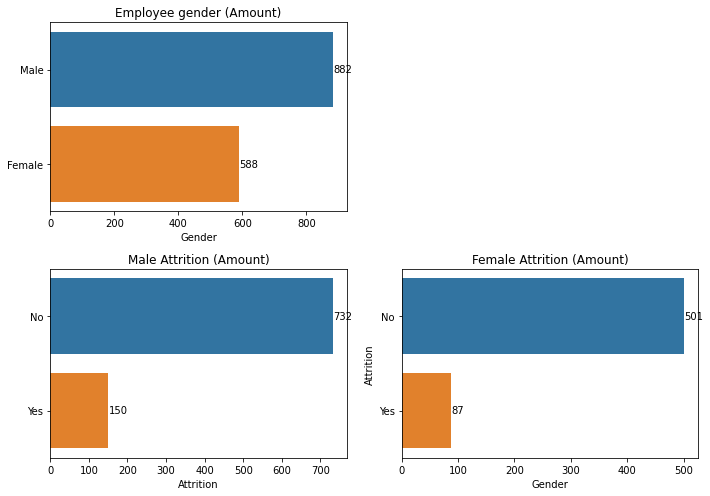

In [1584]:
fig1, axs = plt.subplots(2, 2, figsize=(10,7))
plot_horizontal_bar_chart(gender_count['Gender'], gender_count.index.tolist(), 'Employee Gender', 'Amount', axs[0, 0],'Employee gender (Amount)')
plot_horizontal_bar_chart(male_df['Attrition'].value_counts().to_frame()['Attrition'], male_df['Attrition'].value_counts().to_frame().index.to_list(), 
                          'Gender', 'Attrition', axs[1, 0], 'Male Attrition (Amount)')
plot_horizontal_bar_chart(female_df['Attrition'].value_counts().to_frame()['Attrition'], female_df['Attrition'].value_counts().to_frame().index.to_list(), 
                          'Gender', 'Attrition', axs[1, 1], 'Female Attrition (Amount)')
axs[0, 1].set_visible(False)
plt.tight_layout()

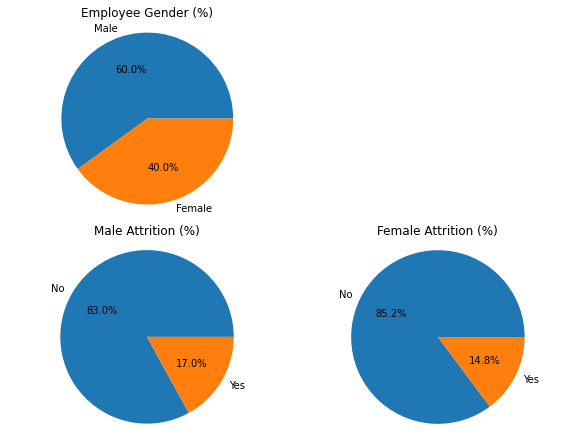

In [1585]:
fig1, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
plot_pie_chart(gender_count.index.tolist(), gender_count['Gender'], axs[0, 0], 'Employee Gender (%)')
plot_pie_chart(male_df['Attrition'].value_counts().to_frame().index.to_list(), male_df['Attrition'].value_counts().to_frame()['Attrition'],axs[1, 0], 'Male Attrition (%)')
plot_pie_chart(female_df['Attrition'].value_counts().to_frame().index.to_list(), female_df['Attrition'].value_counts().to_frame()['Attrition'],axs[1, 1], 'Female Attrition (%)')
axs[0,1].set_visible(False)
plt.show()

**Department**

In [1586]:
department_count = df['Department'].value_counts().to_frame()
department_count

,Department
Research & Development,961
Sales,446
Human Resources,63


In [1587]:
dev_df = df[df['Department'] == 'Research & Development']
sale_df = df[df['Department'] == 'Sales']
hr_df = df[df['Department'] == 'Human Resources']

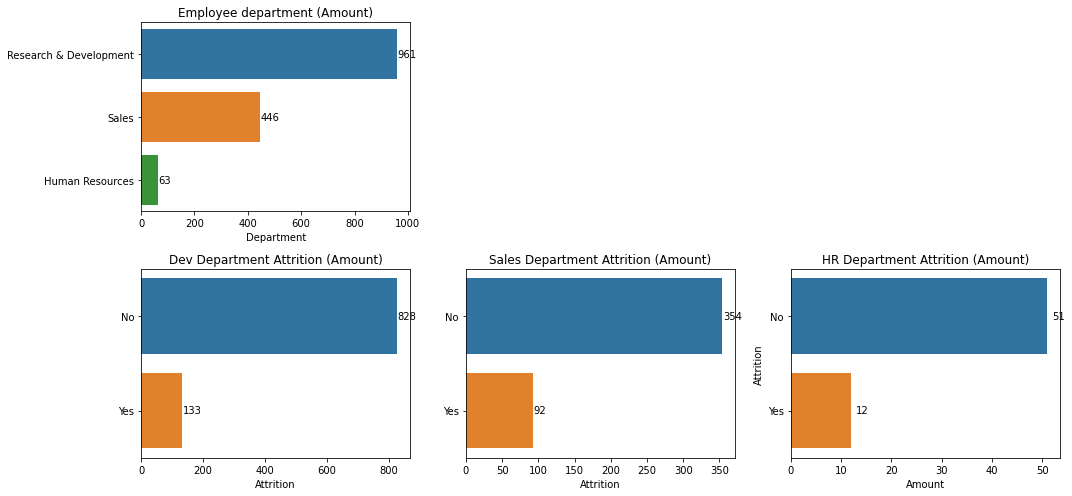

In [1588]:
fig1, axs = plt.subplots(2, 3, figsize=(15,7))
plot_horizontal_bar_chart(department_count['Department'], department_count.index.tolist(), 'Employee Department', 'Amount', axs[0, 0],'Employee department (Amount)')
plot_horizontal_bar_chart(dev_df['Attrition'].value_counts().to_frame()['Attrition'], dev_df['Attrition'].value_counts().to_frame().index.to_list(), 
                          'Amount', 'Attrition', axs[1, 0], 'Dev Department Attrition (Amount)')
plot_horizontal_bar_chart(sale_df['Attrition'].value_counts().to_frame()['Attrition'], sale_df['Attrition'].value_counts().to_frame().index.to_list(), 
                          'Amount', 'Attrition', axs[1, 1], 'Sales Department Attrition (Amount)')
plot_horizontal_bar_chart(hr_df['Attrition'].value_counts().to_frame()['Attrition'], hr_df['Attrition'].value_counts().to_frame().index.to_list(), 
                          'Amount', 'Attrition', axs[1, 2], 'HR Department Attrition (Amount)')
axs[0, 1].set_visible(False)
axs[0, 2].set_visible(False)
plt.tight_layout()

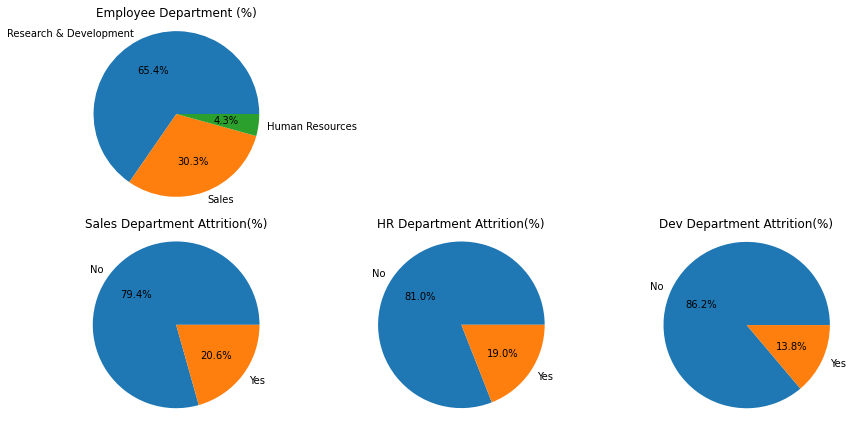

In [1589]:
fig1, axs = plt.subplots(2, 3, figsize=(12,6))
plot_pie_chart(department_count.index.tolist(), department_count['Department'], axs[0, 0], 'Employee Department (%)')
plot_pie_chart(dev_df['Attrition'].value_counts().to_frame().index.to_list(), dev_df['Attrition'].value_counts().to_frame()['Attrition'],axs[1, 2], 'Dev Department Attrition(%)')
plot_pie_chart(sale_df['Attrition'].value_counts().to_frame().index.to_list(), sale_df['Attrition'].value_counts().to_frame()['Attrition'],axs[1, 0], 'Sales Department Attrition(%)')
plot_pie_chart(hr_df['Attrition'].value_counts().to_frame().index.to_list(), hr_df['Attrition'].value_counts().to_frame()['Attrition'],axs[1, 1], 'HR Department Attrition(%)')
axs[0, 1].set_visible(False)
axs[0, 2].set_visible(False)
plt.tight_layout()
plt.show()

**Job Role**

In [1590]:
job_role_count = df['JobRole'].value_counts().to_frame()
job_role_count['Attrition'] = list(map(lambda x: df[(df['JobRole'] == x) & (df['Attrition'] == 'Yes')]['JobRole'].value_counts()[x], job_role_count.index.tolist()))
job_role_count['NoAttrition'] = job_role_count['JobRole'] - job_role_count['Attrition']
job_role_count

,JobRole,Attrition,NoAttrition
Sales Executive,326,57,269
Research Scientist,292,47,245
Laboratory Technician,259,62,197
Manufacturing Director,145,10,135
Healthcare Representative,131,9,122
Manager,102,5,97
Sales Representative,83,33,50
Research Director,80,2,78
Human Resources,52,12,40


In [1591]:
SE_df = job_role_count[job_role_count['JobRole'].index == 'Sales Executive']
RS_df = job_role_count[job_role_count['JobRole'].index == 'Research Scientist']
LT_df = job_role_count[job_role_count['JobRole'].index == 'Laboratory Technician']
MD_df = job_role_count[job_role_count['JobRole'].index == 'Manufacturing Director']
HRe_df = job_role_count[job_role_count['JobRole'].index == 'Healthcare Representative']
M_df = job_role_count[job_role_count['JobRole'].index == 'Manager']
SR_df = job_role_count[job_role_count['JobRole'].index == 'Sales Representative']
RD_df = job_role_count[job_role_count['JobRole'].index == 'Research Director']
HR_df = job_role_count[job_role_count['JobRole'].index == 'Human Resources']

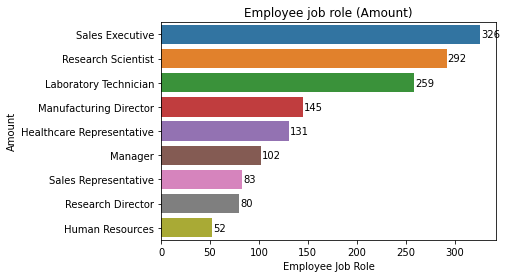

In [1592]:
fig1, axs = plt.subplots()
plot_horizontal_bar_chart(job_role_count['JobRole'], job_role_count.index.tolist(), 'Employee Job Role', 'Amount', axs,'Employee job role (Amount)')
plt.show()

In [1593]:
tickvals = [-300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300]
ticktext = [300, 250, 200, 150, 100, 50, 0, 50, 100, 150, 200, 250, 300]
title = 'Attrition by Job Role Pyramid'
plot_pyramid(job_role_count, tickvals, ticktext, title)

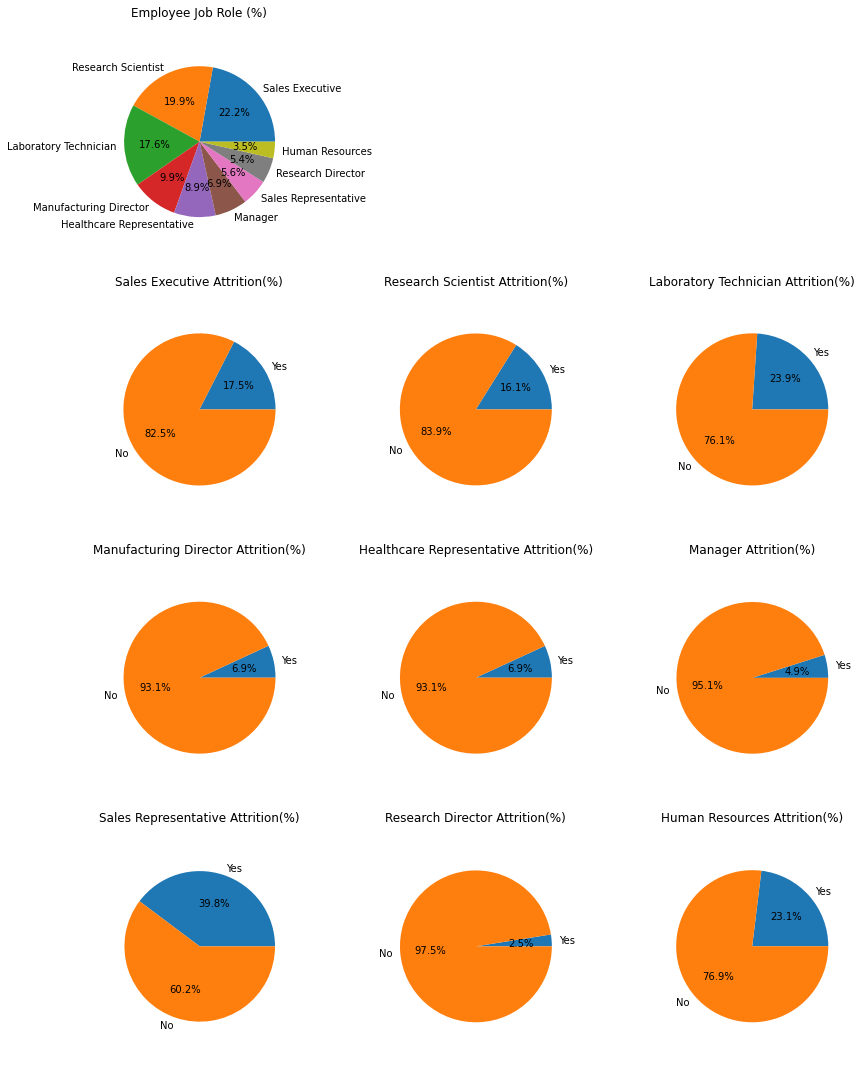

In [1594]:
fig1, axs = plt.subplots(4, 3, figsize=(12,15))
plot_pie_chart(job_role_count.index.tolist(), job_role_count['JobRole'], axs[0, 0], 'Employee Job Role (%)')
plot_pie_chart(['Yes', 'No'], [SE_df['Attrition'].item(), SE_df['NoAttrition'].item()], axs[1, 0], 'Sales Executive Attrition(%)')
plot_pie_chart(['Yes', 'No'], [RS_df['Attrition'].item(), RS_df['NoAttrition'].item()], axs[1, 1], 'Research Scientist Attrition(%)')
plot_pie_chart(['Yes', 'No'], [LT_df['Attrition'].item(), LT_df['NoAttrition'].item()], axs[1, 2], 'Laboratory Technician Attrition(%)')
plot_pie_chart(['Yes', 'No'], [MD_df['Attrition'].item(), MD_df['NoAttrition'].item()], axs[2, 0], 'Manufacturing Director Attrition(%)')
plot_pie_chart(['Yes', 'No'], [HRe_df['Attrition'].item(), HRe_df['NoAttrition'].item()], axs[2, 1], 'Healthcare Representative Attrition(%)')
plot_pie_chart(['Yes', 'No'], [M_df['Attrition'].item(), M_df['NoAttrition'].item()], axs[2, 2], 'Manager Attrition(%)')
plot_pie_chart(['Yes', 'No'], [SR_df['Attrition'].item(), SR_df['NoAttrition'].item()], axs[3, 0], 'Sales Representative Attrition(%)')
plot_pie_chart(['Yes', 'No'], [RD_df['Attrition'].item(), RD_df['NoAttrition'].item()], axs[3, 1], 'Research Director Attrition(%)')
plot_pie_chart(['Yes', 'No'], [HR_df['Attrition'].item(), HR_df['NoAttrition'].item()], axs[3, 2], 'Human Resources Attrition(%)')
axs[0, 1].set_visible(False)
axs[0, 2].set_visible(False)
plt.tight_layout()
plt.show()

* Các vị trí cấp cao (Manufacturing Director, Research Director, Manager), Healcare có tỉ lệ nghỉ việc thấp (< 7%)
* Các vị trí công việc khác có tỉ lệ nghỉ việc tương đối cao

**Education Field**

In [1595]:
education_field_count = df['EducationField'].value_counts().to_frame()
education_field_count['Attrition'] = list(map(lambda x: df[(df['EducationField'] == x) & (df['Attrition'] == 'Yes')]['EducationField'].value_counts()[x], education_field_count.index.tolist()))
education_field_count['NoAttrition'] = education_field_count['EducationField'] - education_field_count['Attrition']
education_field_count

,EducationField,Attrition,NoAttrition
Life Sciences,606,89,517
Medical,464,63,401
Marketing,159,35,124
Technical Degree,132,32,100
Other,82,11,71
Human Resources,27,7,20


In [1596]:
LS_df = education_field_count[education_field_count.index == 'Life Sciences']
Me_df = education_field_count[education_field_count.index == 'Medical']
Ma_df = education_field_count[education_field_count.index == 'Marketing']
TD_df = education_field_count[education_field_count.index == 'Technical Degree']
O_df = education_field_count[education_field_count.index == 'Other']
HR_df = education_field_count[education_field_count.index == 'Human Resources']

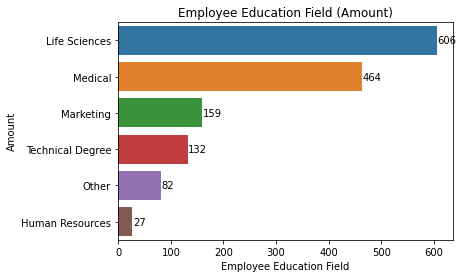

In [1597]:
fig1, axs = plt.subplots()
plot_horizontal_bar_chart(education_field_count['EducationField'], education_field_count.index.tolist(), 'Employee Education Field', 'Amount', axs,'Employee Education Field (Amount)')
plt.show()

In [1598]:
tickvals = [-550, -500, -450, -400, -350, -300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
ticktext = [550, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50, 0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
title = 'Attrition by Education Field Pyramid'
plot_pyramid(education_field_count, tickvals, ticktext, title)

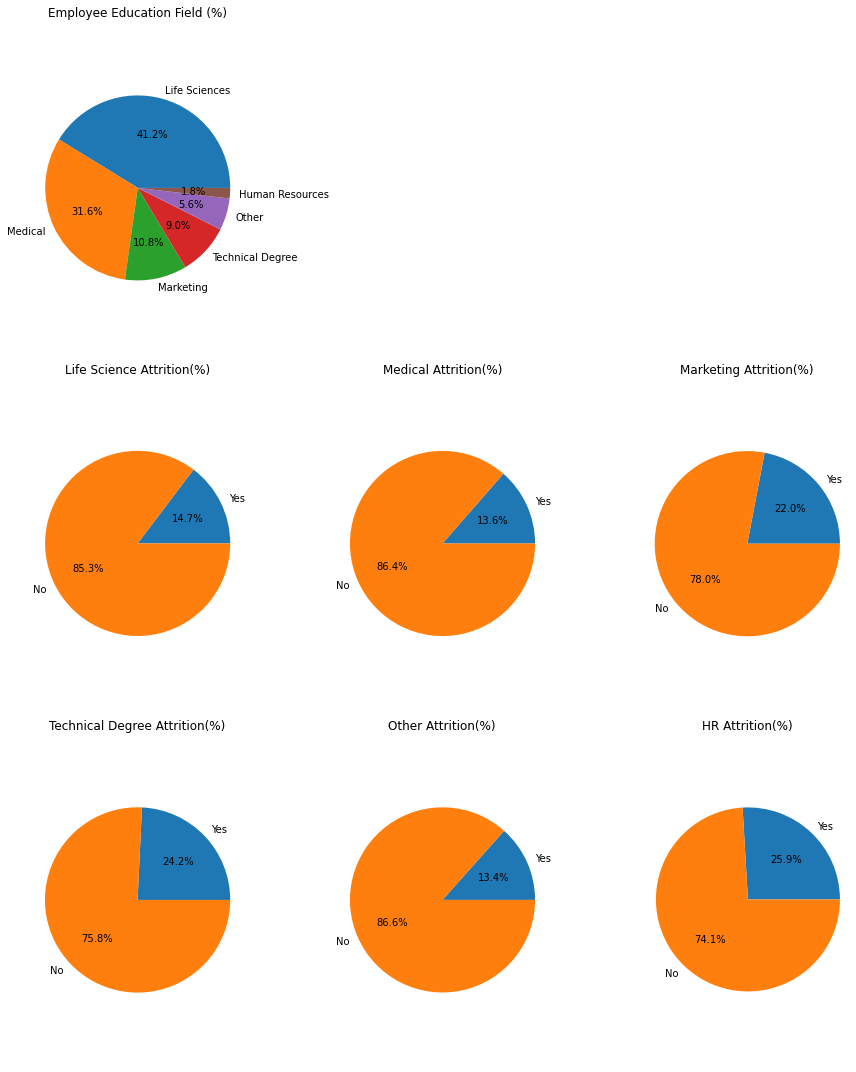

In [1599]:
fig1, axs = plt.subplots(3, 3, figsize=(12,15))
plot_pie_chart(education_field_count.index.tolist(), education_field_count['EducationField'], axs[0, 0], 'Employee Education Field (%)')
plot_pie_chart(['Yes', 'No'], [LS_df['Attrition'].item(), LS_df['NoAttrition'].item()], axs[1, 0], 'Life Science Attrition(%)')
plot_pie_chart(['Yes', 'No'], [Me_df['Attrition'].item(), Me_df['NoAttrition'].item()], axs[1, 1], 'Medical Attrition(%)')
plot_pie_chart(['Yes', 'No'], [Ma_df['Attrition'].item(), Ma_df['NoAttrition'].item()], axs[1, 2], 'Marketing Attrition(%)')
plot_pie_chart(['Yes', 'No'], [TD_df['Attrition'].item(), TD_df['NoAttrition'].item()], axs[2, 0], 'Technical Degree Attrition(%)')
plot_pie_chart(['Yes', 'No'], [O_df['Attrition'].item(), O_df['NoAttrition'].item()], axs[2, 1], 'Other Attrition(%)')
plot_pie_chart(['Yes', 'No'], [HR_df['Attrition'].item(), HR_df['NoAttrition'].item()], axs[2, 2], 'HR Attrition(%)')
axs[0, 1].set_visible(False)
axs[0, 2].set_visible(False)
plt.tight_layout()
plt.show()

**..**

In [1615]:
df2 = df_grp = df1[['Education', 'JobRole']].value_counts().to_frame(name='Amount').reset_index()
df_grp = df2.groupby(['Education', 'JobRole'], as_index=False).sum()
df_pivot = df_grp.pivot(index='JobRole', columns='Education', values='Amount')
df_pivot

Education,1,2,3,4,5
JobRole,,,,,
Healthcare Representative,15.0,21.0,48.0,44.0,3.0
Human Resources,5.0,12.0,22.0,10.0,3.0
Laboratory Technician,35.0,57.0,104.0,58.0,5.0
Manager,9.0,19.0,40.0,29.0,5.0
Manufacturing Director,15.0,33.0,54.0,38.0,5.0
Research Director,7.0,13.0,30.0,23.0,7.0
Research Scientist,37.0,46.0,122.0,79.0,8.0
Sales Executive,27.0,66.0,120.0,101.0,12.0
Sales Representative,20.0,15.0,32.0,16.0,NaN


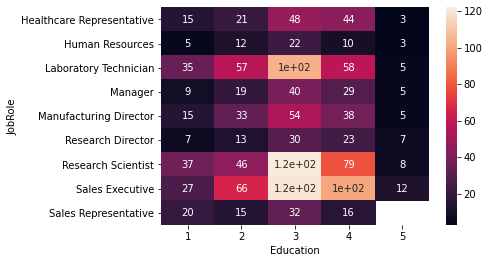

In [1616]:
sns.heatmap(df_pivot, annot=True)

## **Hypothesis testing**

**<h2> Attrition <h2>**

In [1600]:
df1 = pd.DataFrame(df)
df1['Attrition'] = df1['Attrition'].apply(lambda x: 0 if x == 'No' else 1)

**Business Travel**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các loại tần suất đi công tác
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các loại tần suất đi công tác



In [1601]:
# model = ols('Attrition~C(BusinessTravel)', data=df1).fit()

In [1602]:
# aov = sm.stats.anova_lm(model, typ=2)
# aov

In [1603]:
# f_oneway(df1['Attrition'][df1['BusinessTravel'] == 'Travel_Rarely'],
#          df1['Attrition'][df1['BusinessTravel'] == 'Travel_Frequently'],
#         df1['Attrition'][df1['BusinessTravel'] == 'Non-Travel'])


In [1604]:
one_way_anova(df1, 'BusinessTravel')

F_onewayResult(statistic=12.26835294184309, pvalue=5.1998333569549645e-06)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các loại tần suất đi công tác => **BusinessTravel có ảnh hưởng tới Attrition rate**

**Department**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các phòng ban khác nhau
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các phòng ban khác nhau



In [1605]:
one_way_anova(df1, 'Department')

F_onewayResult(statistic=5.426843272582723, pvalue=0.004485674813058454)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các phòng ban khác nhau => **Department có ảnh hưởng tới Attrition rate**

**Education Field**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các lĩnh vực giáo dục khác nhau
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các lĩnh vực giáo dục khác nhau

In [1606]:
one_way_anova(df1, 'EducationField')

F_onewayResult(statistic=3.2270317788051086, pvalue=0.006665621672291533)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các lĩnh vực giáo dục khác nhau => **EducationField có ảnh hưởng tới Attrition rate**

**Gender**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa nam và nữ
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa nam và nữ

In [1607]:
one_way_anova(df1, 'Gender')

F_onewayResult(statistic=1.2745870687662155, pvalue=0.2590923641414023)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa là 74% => không có sự khác biệt tỉ lệ nghỉ việc giữa nam và nữ => **Gender không ảnh hưởng tới Attrition rate**

**JobRole**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các vai trò công việc
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các vai trò công việc

In [1608]:
one_way_anova(df1, 'JobRole')

F_onewayResult(statistic=11.374753732967797, pvalue=9.562555450860023e-16)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các vai trò công việc khác nhau => **JobRole có ảnh hưởng tới Attrition rate**

**MaritalStatus**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa nhân viên đã và chưa kết hôn
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa nhân viên đã và chưa kết hôn

In [1609]:
one_way_anova(df1, 'MaritalStatus')

F_onewayResult(statistic=23.78156546845813, pvalue=6.850067559825624e-11)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa nhân viên đã và chưa kết hôn => **MaritalStatus có ảnh hưởng tới Attrition rate**

**OverTime**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa nhân viên có tăng ca và không tăng ca
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa nhân viên có tăng ca và không tăng ca

In [1610]:
one_way_anova(df1, 'OverTime')

F_onewayResult(statistic=94.65645707175152, pvalue=1.0092540336562444e-21)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa nhân viên có tăng ca và không tăng ca => **MaritalStatus có ảnh hưởng tới Attrition rate**

**Age**


*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các khoảng độ tuổi của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các khoảng độ tuổi của nhân viên

In [1611]:
df1['Age_bins'] = pd.cut(x=df1['Age'], bins=[17, 28, 38, 48, 60])

In [1612]:
one_way_anova(df1, 'Age_bins')

F_onewayResult(statistic=13.37061686704299, pvalue=1.3038441648164675e-08)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các khoảng độ tuổi của nhân viên => **Age có ảnh hưởng tới Attrition rate**

**DistanceFromHome**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các khoảng về khoảng cách từ nhà đến công ty của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các khoảng về khoảng cách từ nhà đến công ty của nhân viên

In [1613]:
df1['DistanceFromHome_bins'] = pd.cut(x=df1['DistanceFromHome'], bins=[0, 7, 14, 21, 29])

In [1614]:
one_way_anova(df1, 'DistanceFromHome_bins')

F_onewayResult(statistic=3.5259916140841407, pvalue=0.014468123188561357)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các khoảng về khoảng cách từ nhà đến công ty của nhân viên => **DistanceFromHome có ảnh hưởng tới Attrition rate**

**Education**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các trình độ học vấn khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biết về tỉ lệ nghỉ việc các trình độ học vấn khác nhau của nhân viên

In [1617]:
one_way_anova(df1, 'Education')

F_onewayResult(statistic=0.7674813402162518, pvalue=0.5463777137937058)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa 45% => không có sự khác biết về tỉ lệ nghỉ việc giữa các trình độ học vấn khác nhau của nhân viên => **Education không ảnh hưởng tới Attrition rate**

**EnvironmentSatisfaction**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức độ hài lòng về môi trường làm việc khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ hài lòng về môi trường làm việc khác nhau của nhân viên

In [1618]:
one_way_anova(df1, 'EnvironmentSatisfaction')

F_onewayResult(statistic=7.597185641660514, pvalue=4.8368800677021675e-05)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các mức độ hài lòng về môi trường làm việc khác nhau của nhân viên => **EnvironmentSatisfaction có ảnh hưởng tới Attrition rate**

**HourlyRate**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức tiền công theo giờ khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức tiền công theo giờ khác nhau của nhân viên

In [1619]:
df1['HourlyRate_bins'] = pd.cut(x=df1['HourlyRate'], bins=[29, 45, 60, 75, 90, 100])

In [1620]:
df1['HourlyRate_bins'].describe()

count         1470
unique           5
top       (75, 90]
freq           327
Name: HourlyRate_bins, dtype: object

In [1621]:
one_way_anova(df1, 'HourlyRate_bins')

F_onewayResult(statistic=0.7563183510859414, pvalue=0.553781137903282)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa là 45% => không có sự khác biết về tỉ lệ nghỉ việc giữa các mức tiền công theo giờ khác nhau của nhân viên => **HourlyRate không ảnh hưởng tới Attrition rate**

**JobInvolvement**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức độ tham gia công việc khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ tham gia công việc khác nhau của nhân viên

In [1622]:
one_way_anova(df1, 'JobInvolvement')

F_onewayResult(statistic=9.658705500376106, pvalue=2.585146625138106e-06)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các mức độ tham gia công việc khác nhau của nhân viên => **JobInvolvement có ảnh hưởng tới Attrition rate**

**JobLevel**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức độ công việc khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ công việc khác nhau của nhân viên

In [1623]:
one_way_anova(df1, 'JobLevel')

F_onewayResult(statistic=19.0084454700361, pvalue=2.975150100310332e-15)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các mức độ công việc khác nhau của nhân viên => **JobLevel có ảnh hưởng tới Attrition rate**

**JobSatisfaction**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức độ hài lòng với công việc khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ hài lòng với công việc khác nhau của nhân viên

In [1624]:
one_way_anova(df1, 'JobSatisfaction')

F_onewayResult(statistic=5.8892788518552335, pvalue=0.0005398918860203367)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các mức độ hài lòng với công việc khác nhau của nhân viên => **JobSatisfaction có ảnh hưởng tới Attrition rate**

**MonthlyIncome**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức thu nhập hàng tháng khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức thu nhập hàng tháng khác nhau của nhân viên

In [1625]:
df1['MonthlyIncome_bins'] = pd.cut(x=df1['MonthlyIncome'], bins=[1000, 5000, 10000, 15000, 20000])

In [1626]:
one_way_anova(df1, 'MonthlyIncome_bins')

F_onewayResult(statistic=14.190812243833498, pvalue=4.050982111143871e-09)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biết về tỉ lệ nghỉ việc giữa các mức thu nhập hàng tháng khác nhau của nhân viên => **MonthlyIncome có ảnh hưởng tới Attrition rate**

**MonthlyRate**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức MonthlyRate khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức MonthlyRate khác nhau của nhân viên

In [1627]:
df1['MonthlyRate_bins'] = pd.cut(x=df1['MonthlyRate'], bins=5)

In [1628]:
one_way_anova(df1, 'MonthlyRate_bins')

F_onewayResult(statistic=0.5404973972365893, pvalue=0.706015808151448)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa là 29% => không có sự khác biết về tỉ lệ nghỉ việc giữa các mức thu nhập hàng tháng khác nhau của nhân viên => **MonthlyRate không ảnh hưởng tới Attrition rate**

**NumCompaniesWorked**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa số lượng công ty đã từng làm việc khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa số lượng công ty đã từng làm việc khác nhau của nhân viên

In [1629]:
df1['NumCompaniesWorked_bins'] = pd.cut(x=df1['NumCompaniesWorked'], bins=4)

In [1630]:
one_way_anova(df1, 'NumCompaniesWorked_bins')

F_onewayResult(statistic=4.632450692354977, pvalue=0.0031362106895095536)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa số lượng công ty đã từng làm việc khác nhau của nhân viên => **NumCompaniesWorked có ảnh hưởng tới Attrition rate**

**PercentSalaryHike**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức tỉ lệ tăng lương khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức tỉ lệ tăng lương khác nhau của nhân viên

In [1631]:
df1['PercentSalaryHike_bins'] = pd.cut(x=df1['PercentSalaryHike'], bins=3)

In [1632]:
one_way_anova(df1, 'PercentSalaryHike_bins')

F_onewayResult(statistic=0.3177861899691451, pvalue=0.7278084598581223)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa là 27% => không có sự khác biệt về tỉ lệ nghỉ việc giữa các mức tỉ lệ tăng lương khác nhau của nhân viên => **PercentSalaryHike không ảnh hưởng tới Attrition rate**

**PerformanceRating**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức PerformanceRating khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức PerformanceRating khác nhau của nhân viên

In [1633]:
one_way_anova(df1, 'PerformanceRating')

F_onewayResult(statistic=0.01225039553422336, pvalue=0.9118840421067758)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa là 9% => không có sự khác biệt về tỉ lệ nghỉ việc giữa các mức PerformanceRating khác nhau của nhân viên => **PerformanceRating không ảnh hưởng tới Attrition rate**

**RelationshipSatisfaction**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức độ hài lòng về các mối quan hệ khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ hài lòng về các mối quan hệ khác nhau của nhân viên

In [1634]:
one_way_anova(df1, 'RelationshipSatisfaction')

F_onewayResult(statistic=1.7485028454735576, pvalue=0.15518102813593446)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa là 84% => không có sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ hài lòng về các mối quan hệ khác nhau của nhân viên => **RelationshipSatisfaction không ảnh hưởng tới Attrition rate**

**StockOptionLevel**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các StockOptionLevel khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa StockOptionLevel khác nhau của nhân viên

In [1635]:
one_way_anova(df1, 'StockOptionLevel')

F_onewayResult(statistic=21.010596070828136, pvalue=2.5027655843129855e-13)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các StockOptionLevel khác nhau của nhân viên => **StockOptionLevel có ảnh hưởng tới Attrition rate**

**TotalWorkingYears**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa tổng số năm làm việc khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa tổng số năm làm việc khác nhau của nhân viên

In [1636]:
df1['TotalWorkingYears_bins'] = pd.cut(x=df1['TotalWorkingYears'], bins=8)

In [1637]:
one_way_anova(df1, 'TotalWorkingYears_bins')

F_onewayResult(statistic=8.26167730474947, pvalue=6.509218582541345e-10)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa tổng số năm làm việc khác nhau của nhân viên => **TotalWorkingYears có ảnh hưởng tới Attrition rate**

**TrainingTimesLastYear**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa thời gian đào tạo khác nhau vào năm trước của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa thời gian đào tạo khác nhau vào năm trước của nhân viên

In [1638]:
one_way_anova(df1, 'TrainingTimesLastYear')

F_onewayResult(statistic=2.538544003912546, pvalue=0.01895147009863248)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa thời gian đào tạo khác nhau vào năm trước của nhân viên => **TrainingTimesLastYear có ảnh hưởng tới Attrition rate**

**WorkLifeBalance**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa các mức độ cân bằng giữa cuộc sống và công việc khác nhau nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ cân bằng giữa cuộc sống và công việc khác nhau nhân viên

In [1639]:
one_way_anova(df1, 'WorkLifeBalance')

F_onewayResult(statistic=5.487836904127922, pvalue=0.0009488552748376356)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các mức độ cân bằng giữa cuộc sống và công việc khác nhau nhân viên => **WorkLifeBalance có ảnh hưởng tới Attrition rate**

**YearsAtCompany**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa YearsAtCompany khác nhau nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa YearsAtCompany khác nhau nhân viên

In [1640]:
df1['YearsAtCompany_bins'] = pd.cut(x=df1['YearsAtCompany'], bins=8)

In [1641]:
one_way_anova(df1, 'YearsAtCompany_bins')

F_onewayResult(statistic=4.895471637811031, pvalue=1.774711912124958e-05)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa các YearsAtCompany khác nhau nhân viên => **YearsAtCompany có ảnh hưởng tới Attrition rate**

**YearsInCurrentRole**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa số năm làm việc trong vai trò công việc hiện tại khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa số năm làm việc trong vai trò công việc hiện tại khác nhau của nhân viên

In [1642]:
df1['YearsInCurrentRole_bins'] = pd.cut(x=df1['YearsInCurrentRole'], bins=3)

In [1643]:
one_way_anova(df1, 'YearsInCurrentRole_bins')

F_onewayResult(statistic=8.557071335623231, pvalue=0.00020193949805399027)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa số năm làm việc trong vai trò công việc hiện tại khác nhau nhân viên => **YearsInCurrentRole có ảnh hưởng tới Attrition rate**

**YearsSinceLastPromotion**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa số năm kể từ lần thăng tiến cuối cùng khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa số năm kể từ lần thăng tiến cuối cùng khác nhau của nhân viên

In [1644]:
df1['YearsSinceLastPromotion_bins'] = pd.cut(x=df1['YearsSinceLastPromotion'], bins=3)

In [1645]:
one_way_anova(df1, 'YearsSinceLastPromotion_bins')

F_onewayResult(statistic=0.6102798744741438, pvalue=0.5433366685117054)

* pvalue > 0.05 => chấp nhận H0 với xác suất có ý nghĩa là 66% => không có sự khác biệt về tỉ lệ nghỉ việc giữa số năm kể từ lần thăng tiến cuối cùng khác nhau của nhân viên => **YearsSinceLastPromotion không ảnh hưởng tới Attrition rate**

**YearsWithCurrManager**

*   null hypothesis (H0): không có sự khác biệt tỉ lệ nghỉ việc giữa YearsWithCurrManager khác nhau của nhân viên
*   alternative hypothesis: có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa YearsWithCurrManager khác nhau của nhân viên

In [1646]:
df1['YearsWithCurrManager_bins'] = pd.cut(x=df1['YearsWithCurrManager'], bins=3)

In [1647]:
one_way_anova(df1, 'YearsWithCurrManager_bins')

F_onewayResult(statistic=8.721429178226092, pvalue=0.00017166134060922367)

* pvalue < 0.05 => bác bỏ H0 => có ít nhất một sự khác biệt về tỉ lệ nghỉ việc giữa YearsWithCurrManager khác nhau nhân viên => **YearsWithCurrManager có ảnh hưởng tới Attrition rate**

In [1648]:
print('Các yếu tố ảnh hưởng tới Attrition: ')
for item in impact_to_attrition:
  print('- ', item)

Các yếu tố ảnh hưởng tới Attrition: 
-  BusinessTravel
-  Department
-  EducationField
-  JobRole
-  MaritalStatus
-  OverTime
-  Age
-  DistanceFromHome
-  EnvironmentSatisfaction
-  JobInvolvement
-  JobLevel
-  JobSatisfaction
-  MonthlyIncome
-  NumCompaniesWorked
-  StockOptionLevel
-  TotalWorkingYears
-  TrainingTimesLastYear
-  WorkLifeBalance
-  YearsAtCompany
-  YearsInCurrentRole
-  YearsWithCurrManager


**<h2>Satisfaction<h2>**

In [1649]:
res = hypothesis_testing(df1, 'JobSatisfaction', anova_col_list)

*  BusinessTravel
F_onewayResult(statistic=0.9821326689375071, pvalue=0.37475764819502955)
Chấp nhận H0 với xác suất có ý nghĩa 62.524235180497044%
--------------------------------------------------
*  Department
F_onewayResult(statistic=0.5021228767277305, pvalue=0.6053484180286459)
Chấp nhận H0 với xác suất có ý nghĩa 39.46515819713541%
--------------------------------------------------
*  EducationField
F_onewayResult(statistic=0.955880626351784, pvalue=0.4437603241839597)
Chấp nhận H0 với xác suất có ý nghĩa 55.62396758160403%
--------------------------------------------------
*  Gender
F_onewayResult(statistic=1.6249281030056668, pvalue=0.20260772654830392)
Chấp nhận H0 với xác suất có ý nghĩa 79.73922734516961%
--------------------------------------------------
*  JobRole
F_onewayResult(statistic=0.3652125646086403, pvalue=0.9389893610579624)
Chấp nhận H0 với xác suất có ý nghĩa 6.101063894203762%
--------------------------------------------------
*  MaritalStatus
F_onewayResult(

In [1650]:
print_res(res, 'JobSatisfaction')

Các yếu tố ảnh hưởng tới JobSatisfaction: 
-  NumCompaniesWorked


**<h2>EnvironmentSatisfaction<h2>**

In [1651]:
res = hypothesis_testing(df1, 'EnvironmentSatisfaction', anova_col_list)

*  BusinessTravel
F_onewayResult(statistic=0.11865152086672413, pvalue=0.8881257591781646)
Chấp nhận H0 với xác suất có ý nghĩa 11.18742408218354%
--------------------------------------------------
*  Department
F_onewayResult(statistic=0.5747652749053414, pvalue=0.5629636591377534)
Chấp nhận H0 với xác suất có ý nghĩa 43.70363408622466%
--------------------------------------------------
*  EducationField
F_onewayResult(statistic=1.5750621591041187, pvalue=0.1639927635769397)
Chấp nhận H0 với xác suất có ý nghĩa 83.60072364230604%
--------------------------------------------------
*  Gender
F_onewayResult(statistic=0.00037930635770939606, pvalue=0.9844641975864159)
Chấp nhận H0 với xác suất có ý nghĩa 1.5535802413584099%
--------------------------------------------------
*  JobRole
F_onewayResult(statistic=1.2190555948776438, pvalue=0.28375260917113615)
Chấp nhận H0 với xác suất có ý nghĩa 71.62473908288638%
--------------------------------------------------
*  MaritalStatus
F_onewayRe

In [1652]:
print_res(res, 'EnvironmentSatisfaction')

Các yếu tố ảnh hưởng tới EnvironmentSatisfaction: 
-  OverTime


**<h2>RelationshipSatisfaction<h2>**

In [1653]:
res = hypothesis_testing(df1, 'RelationshipSatisfaction', anova_col_list)

*  BusinessTravel
F_onewayResult(statistic=1.0974210553903598, pvalue=0.3340044630155087)
Chấp nhận H0 với xác suất có ý nghĩa 66.59955369844913%
--------------------------------------------------
*  Department
F_onewayResult(statistic=0.902311342521813, pvalue=0.40585602099732065)
Chấp nhận H0 với xác suất có ý nghĩa 59.414397900267936%
--------------------------------------------------
*  EducationField
F_onewayResult(statistic=0.901172404506994, pvalue=0.4794087666222866)
Chấp nhận H0 với xác suất có ý nghĩa 52.05912333777134%
--------------------------------------------------
*  Gender
F_onewayResult(statistic=0.7681104152760331, pvalue=0.3809456347397697)
Chấp nhận H0 với xác suất có ý nghĩa 61.905436526023024%
--------------------------------------------------
*  JobRole
F_onewayResult(statistic=0.5974525303861897, pvalue=0.7806426574236731)
Chấp nhận H0 với xác suất có ý nghĩa 21.93573425763269%
--------------------------------------------------
*  MaritalStatus
F_onewayResult(s

In [1654]:
print_res(res, 'RelationshipSatisfaction')

Các yếu tố ảnh hưởng tới RelationshipSatisfaction: 
-  YearsSinceLastPromotion


## **Feature selection**

## **Feature transform & PCA**

## **Train test split**

## **Train model**

## **Tuning**

## **Run back test**

## **Strategy analysis**

## **Deploy model**

## **Model performance monitoring**